In [79]:
import pickle   #specialized format for data
import numpy as np

In [80]:
with open('train_qa.txt', 'rb') as f:   #read as binary
    train_data = pickle.load(f)

In [81]:
with open('test_qa.txt', 'rb') as f:   #read as binary
    test_data = pickle.load(f)

10000 points for trainig data and <br>
1000 points for test data <br>
each training example is a tuple (story, question, answer)

In [82]:
'''
Creating the vocabulary
'''
all_data = test_data + train_data
vocab = set()   #set is an unordered list of unique elements

for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))
    vocab.add('no')
    vocab.add('yes')
    
vocab_len = len(vocab) + 1   #we will use it later
print(vocab_len)

38


In [83]:
'''
We want to the longest story for later use
'''
all_story_lens = [len(data[0]) for data in all_data]
max_story_len = max(all_story_lens)
print(max_story_len)

156


In [84]:
'''
We want to the longest question for later use
'''
all_question_lens = [len(data[1]) for data in all_data]
max_question_len = max(all_question_lens)
print(max_question_len)

6


In [85]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [86]:
'''
Create a dictionary that maps every word of the vocabularu to an index
'''
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

tokenizer.word_index

{'yes': 1,
 'kitchen': 2,
 'garden': 3,
 'went': 4,
 'football': 5,
 'picked': 6,
 '?': 7,
 'in': 8,
 'took': 9,
 'moved': 10,
 'put': 11,
 'apple': 12,
 'mary': 13,
 'the': 14,
 'dropped': 15,
 'is': 16,
 'to': 17,
 '.': 18,
 'hallway': 19,
 'up': 20,
 'bedroom': 21,
 'journeyed': 22,
 'no': 23,
 'milk': 24,
 'there': 25,
 'travelled': 26,
 'got': 27,
 'back': 28,
 'sandra': 29,
 'daniel': 30,
 'down': 31,
 'bathroom': 32,
 'office': 33,
 'left': 34,
 'discarded': 35,
 'grabbed': 36,
 'john': 37}

In [87]:
'''
Make lists of stories, qustions and answers
'''
train_story_text = []
train_question_text = []
train_answer_text = []

for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answer_text.append(answer)

In [88]:
'''
Same for test_data
'''
test_story_text = []
test_question_text = []
test_answer_text = []

for story, question, answer in test_data:
    test_story_text.append(story)
    test_question_text.append(question)
    test_answer_text.append(answer)

In [89]:
'''
-----CREATE PADDED SEQUENCIES-----
VECTORIZING: Conververting words -> indexes,
             sentences -> sequencies of integers
PADDING: Padding vectors with zeros
'''
train_story_seq = tokenizer.texts_to_sequences(train_story_text)
train_story_seq = pad_sequences(train_story_seq, maxlen=max_story_len)

train_question_seq = tokenizer.texts_to_sequences(train_question_text)
train_question_seq = pad_sequences(train_question_seq, maxlen=max_question_len)

In [90]:
'''
Same for test data
'''
test_story_seq = tokenizer.texts_to_sequences(test_story_text)
test_story_seq = pad_sequences(test_story_seq, maxlen=max_story_len)

test_question_seq = tokenizer.texts_to_sequences(test_question_text)
test_question_seq = pad_sequences(test_question_seq, maxlen=max_question_len)

In [91]:
print(f'Index of "yes" is: {tokenizer.word_index.get("yes")}')
print(f'Index of "no" is:  {tokenizer.word_index.get("no")}')

Index of "yes" is: 1
Index of "no" is:  23


In [92]:
'''
Converting train and test answers to one hot representation
'''
train_answer_oh = np.zeros(shape=(len(train_data), vocab_len))
test_answer_oh = np.zeros(shape=(len(train_data), vocab_len))

m = len(train_data)   #m is the number of training examples

for i in range(m):   #i is the trainining example
    train_answer_oh[i][tokenizer.word_index.get(train_answer_text[i])] = 1

y = len(test_data)
for i in range(y):
    test_answer_oh[i][tokenizer.word_index.get(test_answer_text[i])] = 1


In [93]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input,Activation,Dense,Permute,Dropout,add,dot,concatenate,LSTM

In [94]:
# PLACEHOLDER shape=(max_story_len, batch_size)
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [95]:
# INPUT ENCODER M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_len, output_dim=64))
input_encoder_m.add(Dropout(0.33))

# OUTPUT
# (m, max_story_len, embedding_dim)

In [96]:
# INPUT ENCODER C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_len, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.33))

# OUTPUT
# (m, max_story_len, max_question_len)

In [97]:
# QUESTION ENCODER
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_len, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.33))

# OUTPUT
# (m, max_question_len, embedding_dim)

In [98]:
# ENCODED --> ENCODER(INPUT)
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded= question_encoder(question)

In [99]:
match = dot([input_encoded_m, question_encoded], axes=(2,2))
match = Activation('softmax')(match)

In [100]:
response = add([match, input_encoded_c])
print(response.shape)
response = Permute((2,1))(response)   #changes the axes
print(response.shape)

(None, 156, 6)
(None, 6, 156)


In [101]:
question_encoded.shape

TensorShape([None, 6, 64])

In [102]:
answer = concatenate([response, question_encoded])
answer.shape

TensorShape([None, 6, 220])

In [103]:
answer = LSTM(units=32)(answer)

In [104]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_len)(answer)   #(samples,vocab_size)
answer

<tf.Tensor 'dense_2/BiasAdd:0' shape=(None, 38) dtype=float32>

In [105]:
answer = Activation('softmax')(answer)

In [106]:
model = Model([input_sequence,question], answer)

In [108]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [109]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       multiple             2432        input_3[0][0]                    
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 6, 64)        2432        input_4[0][0]                    
____________________________________________________________________________________________

In [111]:
history = model.fit([train_story_seq, train_question_seq], train_answer_oh, batch_size=128, epochs=200)

Epoch 1/200
10000/10000 [==============================] - 2s 209us/step - loss: 0.7455 - accuracy: 0.5094
Epoch 2/200
10000/10000 [==============================] - 2s 200us/step - loss: 0.7327 - accuracy: 0.4984
Epoch 3/200
10000/10000 [==============================] - 2s 206us/step - loss: 0.7201 - accuracy: 0.5002
Epoch 4/200
10000/10000 [==============================] - 2s 221us/step - loss: 0.7111 - accuracy: 0.4975
Epoch 5/200
10000/10000 [==============================] - 3s 252us/step - loss: 0.7080 - accuracy: 0.4942
Epoch 6/200
10000/10000 [==============================] - 3s 274us/step - loss: 0.7039 - accuracy: 0.5052
Epoch 7/200
10000/10000 [==============================] - 2s 239us/step - loss: 0.7026 - accuracy: 0.4986
Epoch 8/200
10000/10000 [==============================] - 2s 250us/step - loss: 0.7012 - accuracy: 0.4989
Epoch 9/200
10000/10000 [==============================] - 3s 260us/step - loss: 0.6996 - accuracy: 0.5052
Epoch 10/200
10000/10000 [===========

Epoch 77/200
10000/10000 [==============================] - 3s 270us/step - loss: 0.5522 - accuracy: 0.7139
Epoch 78/200
10000/10000 [==============================] - 2s 236us/step - loss: 0.5553 - accuracy: 0.7119
Epoch 79/200
10000/10000 [==============================] - 2s 245us/step - loss: 0.5502 - accuracy: 0.7137
Epoch 80/200
10000/10000 [==============================] - 3s 285us/step - loss: 0.5449 - accuracy: 0.7221
Epoch 81/200
10000/10000 [==============================] - 2s 244us/step - loss: 0.5433 - accuracy: 0.7204
Epoch 82/200
10000/10000 [==============================] - 3s 252us/step - loss: 0.5388 - accuracy: 0.7223
Epoch 83/200
10000/10000 [==============================] - 3s 278us/step - loss: 0.5351 - accuracy: 0.7260
Epoch 84/200
10000/10000 [==============================] - 3s 259us/step - loss: 0.5360 - accuracy: 0.7269
Epoch 85/200
10000/10000 [==============================] - 2s 221us/step - loss: 0.5341 - accuracy: 0.7238
Epoch 86/200
10000/10000 [==

10000/10000 [==============================] - 3s 309us/step - loss: 0.3892 - accuracy: 0.8253
Epoch 153/200
10000/10000 [==============================] - 2s 249us/step - loss: 0.3829 - accuracy: 0.8262
Epoch 154/200
10000/10000 [==============================] - 3s 262us/step - loss: 0.3763 - accuracy: 0.8313
Epoch 155/200
10000/10000 [==============================] - 3s 260us/step - loss: 0.3805 - accuracy: 0.8270
Epoch 156/200
10000/10000 [==============================] - 2s 233us/step - loss: 0.3773 - accuracy: 0.8321
Epoch 157/200
10000/10000 [==============================] - 3s 265us/step - loss: 0.3789 - accuracy: 0.8284
Epoch 158/200
10000/10000 [==============================] - 3s 261us/step - loss: 0.3817 - accuracy: 0.8275
Epoch 159/200
10000/10000 [==============================] - 3s 265us/step - loss: 0.3760 - accuracy: 0.8314
Epoch 160/200
10000/10000 [==============================] - 3s 264us/step - loss: 0.3697 - accuracy: 0.8313
Epoch 161/200
10000/10000 [======

In [112]:
# filename = 'chatbot_120_epochs.h5'
filename = 'chatbot_200_epochs.h5'
model.save(filename)

In [113]:
from keras.models import load_model

In [114]:
model = load_model('chatbot_200_epochs.h5')

/home/kaml/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


dict_keys(['loss', 'accuracy'])


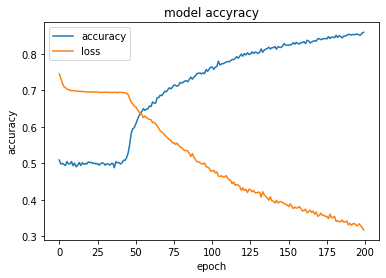

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accyracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'loss'])
plt.show()

In [116]:
predictions = model.predict([test_story_seq, test_question_seq])

In [117]:
predictions.shape

(1000, 38)

In [118]:
predicted_answers = []
for i in range(len(test_data)):
    val_max = np.argmax(predictions[i])
    for key, val in tokenizer.word_index.items():
        if val == val_max:
            predicted_answers.append(key)

In [119]:
for i in range(len(test_data)):   
    if predicted_answers[i] == 'yes':
        predicted_answers[i] = 1.0
    else:
        predicted_answers[i] = 0.0

In [120]:
for i in range(len(test_data)):   
    if test_answer_text[i] == 'yes':
        test_answer_text[i] = 1.0
    else:
        test_answer_text[i] = 0.0

In [121]:
correct_ans = 0
for i in range(len(test_data)):
    if predicted_answers[i] == test_answer_text[i]:
        correct_ans += 1
        
accuracy = correct_ans / len(test_data)
print(accuracy)

0.798


In [122]:
my_story = [[]]   #ATTENTION!!! Must be a list of lists
my_story[0] = ("John is in the kitchen.").split()
my_story_seq = tokenizer.texts_to_sequences(my_story)
my_story_seq = pad_sequences(my_story_seq, maxlen=max_story_len)

In [123]:
my_question = [[]]
my_question[0] = ('Is John in the bathroom?').split()
my_question_seq = tokenizer.texts_to_sequences(my_question)
my_question_seq = pad_sequences(my_question_seq, maxlen=max_question_len)

In [124]:
my_prediction = model.predict([my_story_seq, my_question_seq])

In [125]:
my_prediction.shape

(1, 38)

In [126]:
my_val_max = np.argmax(my_prediction)
my_val_max

23

In [127]:
for key, val in tokenizer.word_index.items():
    if val == my_val_max:
        k = key
print(k)

no
